## Discover

1. Covid presents us with new challenges
2. We need to be able to adapt to the ever changing conditions that we are presented with
3. To do so, we need to be able to know when is the ideal time to start our ideas and seize the opportunities in this uncertain time

## Define

1. Singapore, where we are the most familiar with.
2. When are we able to open up our economy given our government's stance, number of cases, vaccination rates
3. When are we able to flatten the curve

## Develop

1. To do so, we can come up with a multiple linear regression model to calculate what would the stringency index be to allow ease of business and daily activities
2. This will allow opportunity seekers to have a good idea of when Singapore is able to flatten the curve and resume normal life

## Deliver

1. Provide a model for users to key in various parameters and calculate the current expected stringency index

## Problem Statement

### Given a rise in covid-19 cases, the Singaporean Government would always take the necessary precautions to prevent an unpreceeded rise in COVID-19 transmission. This increases the Stringency Index significantly as workplaces, schools closes. In such a case, what would the stringency index of Singapore be?

#### Start with importing Data that outlines Singapore's Covid-19 response

### Data

#### Link to data source: https://github.com/owid/covid-19-data/tree/master/public/data

#### Why is this data used?
1. Sources are clearly documented, for example, all data under Singapore comes directly from Ministry of Health, Singapore, which ensures that data is accurate and not tweaked or false
2. Contains very little missing values and it updated daily
    - Ensures that the data given is current with little errors
    - Missing data is filled using growth trendline analysis using excel
   - Ensures a growth trend in data such as vaccinations rates using values before and after, which can only be increasing
3. Provides a large variety of parameters
    - Ensures that we have a diverse range of parameters to accurately train our model
    - Provides smoothed values to ensure no abnormal values
      - 0 vaccinations prior to discovery of vaccinations and deflivery to Singapore on 31 Dec 2020

#### Model

Features considered:
1. new_cases_smoothed_per_million
    - The number of new cases directly corresponds to the community transmission of COVID-19, giving a clear indication of the prevalence of virus in the community
    - Higher number of new cases signals high transmission rates in the community, leading to higher stringency index to keep new cases low
2. total_cases_per_millon
    - Total numnber of infected individuals is an indication of how many people in the community have natural immunity to COVID-19
    - Higher total cases will lead to herd immnunity, leading to lower stringency index
3. new_deaths_smoothed_per_million
    - Indicates the number of new deaths, an important indicator that is in line with Singapore's stance to be COVID resilient with keeping daily death rates low
    - Higher death rates will signal that the virus is becoming more deadly, leading to a higher stringency index to keep people safe
4. new_tests_smoothed_per_thousand
    - Indicates the number of test done each day, a higher number of testing done will help to ensure that positive cases are picked up earlier and therefore isolated and reduce the spread of the virus
    - Higher number of new tests will lower transmissibility leading to stringency index lowering
5. positive_rate
    - Indicates the percentage of test done that are positive, will give an indication of how many cases are there in the community that is transmitted without being picked up
    - Higher postive rates with higher reservoir of undetected cases will lead to stringency index increasing
6. people_fully_vaccinated_per_hundred
    - Indicates how many people are fully vaccinated and therefore lowering the chances of death as well as having a shorter infectious period, leading to slower transmission rates
    - Higher vaccination rates gives lower death rate and lower transmissibility will likely lead to lower stringency index

- Perform various test to ensure we find the optimal alpha value (learning rate), beta value (starting weight) and number of iterations (times gradient descent is performed)   


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data here is filled with growth trendline analysis using excel and 0's where places are obvious
df = pd.read_csv("Data/Task 2/Singapore_Covid_Data_csv.csv")
display(df)

,location,date,new_cases_smoothed_per_million,total_cases_per_million,new_deaths_smoothed_per_million,reproduction_rate,new_tests_smoothed_per_thousand,positive_rate,people_fully_vaccinated_per_hundred,stringency_index
0,Singapore,1/3/2020,0.445,0.183,0.000,0.56,0.000,0.000,0.000,30.56
1,Singapore,2/3/2020,0.498,0.550,0.000,0.54,0.000,0.000,0.000,30.56
2,Singapore,3/3/2020,0.498,0.550,0.000,0.53,0.000,0.000,0.000,30.56
3,Singapore,4/3/2020,0.445,0.733,0.000,0.57,0.000,0.000,0.000,30.56
4,Singapore,5/3/2020,0.629,0.917,0.000,0.73,0.000,0.000,0.000,30.56
...,...,...,...,...,...,...,...,...,...,...
609,Singapore,31/10/2021,673.998,15193.634,0.288,0.97,4.130,0.163,86.405,44.44
610,Singapore,1/11/2021,655.556,15496.186,0.367,0.94,4.130,0.159,86.445,44.44
611,Singapore,2/11/2021,661.293,15760.782,0.419,0.92,3.976,0.166,86.485,44.44
612,Singapore,3/11/2021,617.050,16116.327,0.472,0.90,3.822,0.161,86.525,44.44


## Multiple Linear Regression

In [8]:
# functions from cohort and homework week 9

def normalize_z(df):
    return ((df - df.mean(axis=0))/df.std(axis=0))

def get_features_targets(df, feature_names, target_names):
    # get df of selected features
    df_feature = df[feature_names]
    # get df of selected targets
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    # number of columns in the dataframe
    cols = len(df_feature.columns)
    # convert df to numpy
    feature = df_feature.to_numpy().reshape(-1,cols)
    array = np.concatenate((np.ones((feature.shape[0],1)), feature), axis = 1)
    return array

def prepare_target(df_target):
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1,cols)
    return target

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    preped_feature = prepare_feature(df_feature)
    return predict_norm(preped_feature, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    indexes = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k = int(test_size * len(indexes))
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    # the above indexes just helps you to get random indexes within the entire data
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    ss_res = np.sum((y-ypred)**2)
    y_mean = np.mean(y)
    ss_tot = np.sum((y-y_mean)**2)
    r_2 = (1-(ss_res/ss_tot))
    return r_2

def mean_squared_error(target, pred):
    num_data = target.shape[0]
    return (1/num_data)*(np.sum((target-pred)**2))

def mean_absolute_error(target,pred):
    num_data = target.shape[0]
    return (1/num_data)*(abs(np.sum(target-pred)))

def compute_cost(X, y, beta): #beta is weighted values, in this case it is just choosen from random values
    J = 0
    number_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error)
    J = (1)/(2*number_of_samples) * error_sq 
    J = J[0][0]
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        beta = beta - alpha *  derivative_error
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

# single function to make the model
# @args
# 1. alpha-value (step for gradient descent)
# 2. beta (starting beta values for gradient descent)
# 3. iterations (number of iterations of gradient descent)
# 4. start (starting row)
# 5. end (last row)
# 6. feature_parameters (features used to train model)
# @return r^2 and mse values + mae value

def make_model(alpha, beta, iterations,start=46,end=None, feature_parameters =["new_cases_smoothed_per_million","total_cases_per_million","new_deaths_smoothed_per_million", "reproduction_rate", "new_tests_smoothed_per_thousand","people_fully_vaccinated_per_hundred","positive_rate"], dataset = "Data/Task 2/Singapore_Covid_Data_csv.csv" , target_column = ["stringency_index"]):
    df = pd.read_csv(dataset)
    
    # Extract the features and the target
    df_features_original_train, df_target = get_features_targets(df.loc[start:end,:],feature_parameters,target_column)

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_original_train,df_target,100,0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # call the predict() method
    pred = predict(df_features_test,beta)

    target = prepare_target(df_target_test)
    r2 = r2_score(target,pred)
    mse = mean_squared_error(target, pred)
    mae = mean_absolute_error(target, pred)
    # print(f"r^2 value = {r2}, mean squared error = {mse}, mean absolute error = {mae}")
    return r2, mse, mae


1. Instantiate values for alpha, beta and number of iterations

* These numbers are calculated to ensure accuaracy of our model

In [9]:
# Instantiate default values for alpha, beta and number of iterations
alpha = 0.01
iterations = 3300
beta = np.zeros((8,1))


### Initial Model

1. Extract from data our features and targets
2. Split data into training and testing for both features and target
3. Normalize features training data using <code>normalize_z()</code>
4. Prepare training features and target for gradient descent to find out beta values
5. Run <code>gradient_descent()</code> to find optimal beta values
6. Run <code>predict()</code> to get target test values and save it into variable <code>pred</code>

#### Generate model matrics

1. Prepare target testing values to be compared with <code>pred</code> variable from above
2. Run <code>r2_score()</code> to calculate the r<sup>2</sup> value 
3. Run <code>mean_squared_error()</code> to calculate the Mean Squared Error

In [12]:
# Initial model
r2_value, mse_value, mae_value = make_model(alpha, beta, iterations)
print(f"r2_value = {r2_value}, mse_value = {mse_value}, mae_value = {mae_value}")


r2_value = 0.8519373130537825, mse_value = 11.289073790212793, mae_value = 0.23002453443723483


### Model Evaluation

To further improve our model, we decided to create a new function that is able to take in parameters to selectively tweak certain parameters to allow us to compare a range of values more efficiently

Here are the features that we used to evaluate our model:
1. Entire Dataset vs Selective Dataset
2. Alpha values
3. Beta values
4. Number of iterations
5. Different features used for training

### Include entire data set vs using only specific values 

In [13]:
## include entire dataset, consisting of all values
r2_value, mse_value, mae_value = make_model(0.01,np.zeros((8, 1)),3300, 0, None)
print(f"r2_value = {r2_value}, mse_value = {mse_value}, mae_value = {mae_value}")


r2_value = 0.435563298045034, mse_value = 45.638099434916036, mae_value = 1.0298599595547584


In [14]:
## change in dataset to include only targeted dataset
r2_value, mse_value, mae_value = make_model(0.01,np.zeros((8, 1)),3300, 46, None)
print(f"r2_value = {r2_value}, mse_value = {mse_value}, mae_value = {mae_value}")


r2_value = 0.8519373130537825, mse_value = 11.289073790212793, mae_value = 0.23002453443723483


### Testing Alpha Values

,alpha_range,r2_value_range,mse_value_range,mae_value_range
0,0.001,0.747319,19.265738,2.172026
1,0.010,0.851937,11.289074,0.230025
2,0.050,0.851984,11.285510,0.230025
3,0.100,0.851984,11.285510,0.230025


[Text(0.5, 1.0, 'Model Metrics against alpha value'), Text(0, 0.5, '')]

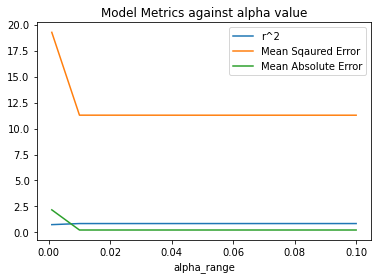

In [15]:
## test for changes to alpha value
alpha_range = [0.001, 0.01, 0.05, 0.1]
r2_value_range = []
mse_value_range = []
mae_value_range = []
for i in alpha_range:
    r2_value, mse_value, mae_value = make_model(i,np.zeros((8,1)),3300, 46, None)
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
    mae_value_range.append(mae_value)
data = pd.DataFrame(list(zip(alpha_range, r2_value_range, mse_value_range, mae_value_range)))
data.columns = ["alpha_range", "r2_value_range", "mse_value_range", "mae_value_range"]
display(data)
sns.lineplot(data = data,x="alpha_range", y="r2_value_range", label = "r^2")
sns.lineplot(data = data,x="alpha_range", y="mse_value_range", label = "Mean Sqaured Error")
sns.lineplot(data = data,x="alpha_range", y="mae_value_range", label = "Mean Absolute Error").set(title="Model Metrics against alpha value", ylabel = "")


# r^2 and mse values become significantly more accurate after 0.01 alpha value
# to reach mse_value with accuracy of up to 2 d.p, you will need to reach 3300 iterations

### Testing Beta Values

In [16]:
beta_range = [np.zeros((8,1)),np.ones((8,1)),np.full((8,1),5),np.full((8,1),10)]
r2_value_range = []
mse_value_range = []
mae_value_range = []
for i in beta_range:
    r2_value, mse_value, mae_value = make_model(0.01,i,3300, 46, None)
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
    mae_value_range.append(mae_value)
data = pd.DataFrame(list(zip(beta_range, r2_value_range, mse_value_range, mae_value_range)))
data.columns = ["beta_range", "r2_value_range", "mse_value_range", "mae_value_range"]
display(data)
# staring beta value makes little difference
# mean squared error is the lowest when beta_range is np.zeros((8,1))

,beta_range,r2_value_range,mse_value_range,mae_value_range
0,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.851937,11.289074,0.230025
1,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.851927,11.289851,0.230025
2,"[[5], [5], [5], [5], [5], [5], [5], [5]]",0.851886,11.292977,0.230025
3,"[[10], [10], [10], [10], [10], [10], [10], [10]]",0.851834,11.296927,0.230025


### Testing Optimal Number of Iterations

,iterations_range,r2_value_range,mse_value_range,mae_value_range
0,100,-4.339631,407.121423,19.534497
1,300,0.697973,23.028140,2.816431
2,500,0.828591,13.069085,0.576550
3,700,0.842572,12.003109,0.276452
4,900,0.847267,11.645144,0.236245
5,1100,0.849394,11.482969,0.230858
6,1300,0.850475,11.400575,0.230136
7,1500,0.851061,11.355872,0.230039
8,1700,0.851395,11.330430,0.230027
9,1900,0.851593,11.315337,0.230025


[Text(0.5, 1.0, 'Model Metrics against number of iterations'),
 Text(0, 0.5, '')]

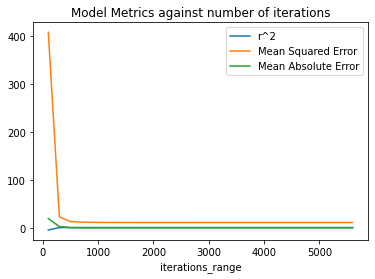

In [17]:
iterations_range = [100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100,3300,3500,3700,3900,4100,4300,4600,4800,5000,5200,5400,5600]
# change in number of iterations
r2_value_range = []
mse_value_range = []
mae_value_range = []
for i in iterations_range:
    r2_value, mse_value, mae_value = make_model(0.01,np.zeros((8,1)), i, 46, None)
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
    mae_value_range.append(mae_value)
data = pd.DataFrame(list(zip(iterations_range, r2_value_range, mse_value_range, mae_value_range)))
data.columns = ["iterations_range", "r2_value_range", "mse_value_range", "mae_value_range"]
display(data)
sns.lineplot(data = data,x="iterations_range", y="r2_value_range", label = "r^2")
sns.lineplot(data = data,x="iterations_range", y="mse_value_range", label = "Mean Squared Error")
sns.lineplot(data = data,x="iterations_range", y="mae_value_range", label = "Mean Absolute Error").set(title="Model Metrics against number of iterations", ylabel = "")

# r^2 and mse values become significantly more accurate after 300 iterations
# to reach mse_value with accuracy of up to 3 d.p, you will need to reach 5200 iterations
# iterations_range[16] = 3300 is where the value of mse becomes accurate to 2dp, r2 and mae is similar before that

### Testing Optimal Features to Consider

In [27]:
# use different features to decide if it would improve MSE and r^2 values
features_evaluated = ["total_cases","new_cases","new_cases_smoothed","total_deaths","new_deaths","new_deaths_smoothed","total_cases_per_million","new_cases_per_million","new_cases_smoothed_per_million","total_deaths_per_million","new_deaths_per_million","new_deaths_smoothed_per_million","reproduction_rate","new_tests_smoothed","new_tests_smoothed_per_thousand","positive_rate","tests_per_case", "total_cases"]
r2_value_range = []
mse_value_range = []
mae_value_range = []
for i in range(1,len(features_evaluated)):
    # print(features_evaluated[i])
    r2_value, mse_value, mae_value = make_model(0.01, np.zeros((i+1,1)), 3300, 46, None, features_evaluated[0:i], "Data/Task 2/singapore_covid_data_total_feature.csv")
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
    mae_value_range.append(mae_value)

# create new array for new col for mse change
r2_value_change = ["NIL"]
for value in range(1,len(r2_value_range)):
    prev_value = r2_value_range[value-1]
    current_value = r2_value_range[value]
    difference_r2 = current_value - prev_value
    if difference_r2 < 0.1:
        difference_r2 = "NSR"
    r2_value_change.append(difference_r2)
# create new array for new col for mse change
mse_value_change = ["NIL"]
for value in range(1,len(mse_value_range)):
    prev_value = mse_value_range[value-1]
    current_value = mse_value_range[value]
    difference_mse = current_value - prev_value
    if difference_mse > -1:
        difference_mse = "NSR"
    mse_value_change.append(difference_mse)
# create new array for new col for mae change
mae_value_change = ["NIL"]
for value in range(1,len(mae_value_range)):
    prev_value_mae = mae_value_range[value-1]
    current_value_mae = mae_value_range[value]
    difference_mae = current_value_mae - prev_value_mae
    if difference_mae > -1:
        difference_mae = "NSR"
    mae_value_change.append(difference_mae)
    

data = pd.DataFrame(list(zip(features_evaluated, r2_value_range, mse_value_range, mae_value_range,r2_value_change, mse_value_change, mae_value_change)))
data.columns = ["features_evaluated", "r2_value_range", "mse_value_range", "mae_value_range","r2_value_change", "mse_value_difference","mae_value_change"]
display(data)

# NSR = No Significant Reduction

,features_evaluated,r2_value_range,mse_value_range,mae_value_range,r2_value_change,mse_value_difference,mae_value_change
0,total_cases,0.254293,53.668781,0.031019,NIL,NIL,NIL
1,new_cases,0.634051,26.337503,0.031019,0.379757,-27.331278,NSR
2,new_cases_smoothed,0.700802,21.533367,0.031019,NSR,-4.804137,NSR
3,total_deaths,0.763901,16.992118,0.031019,NSR,-4.541249,NSR
4,new_deaths,0.763923,16.990543,0.031019,NSR,NSR,NSR
5,new_deaths_smoothed,0.766198,16.826801,0.031019,NSR,NSR,NSR
6,total_cases_per_million,0.770817,16.494357,0.031019,NSR,NSR,NSR
7,new_cases_per_million,0.770738,16.500106,0.031019,NSR,NSR,NSR
8,new_cases_smoothed_per_million,0.770698,16.502936,0.031019,NSR,NSR,NSR
9,total_deaths_per_million,0.772648,16.362630,0.031019,NSR,NSR,NSR


## As shown in the table above, certain features does not result in a significant difference. Having additional features also adds to the computational complexity of the model, thus we remove such features.


#### Features that result in a significant difference are:
1. total_cases
2. new_cases
3. new_cases_smoothed
4. total_deaths
5. new_tests_smoothed

In such cases where many features result in no/very little reduction in the mean squared error of the model, we do not include it into our model as every feature considered will result in additional computational complexity, which would require a significantly higher amount of resources as the model gets larger

Finally, we decided that it is important that we optimise our model using the least amount of features to only include those that will siginificantly affect our model and to reduce our computational complexity


In [29]:
r2_value, mse_value, mae_value = make_model(0.01, np.zeros((6,1)), 3300, 46, None, ["total_cases","new_cases", "new_cases_smoothed", "total_deaths","new_tests_smoothed"],"Data/Task 2/singapore_covid_data_total_feature.csv")
print(f"r2_value = {r2_value}, mse_value = {mse_value}, mae_value = {mae_value}")


r2_value = 0.7842477046029241, mse_value = 15.527772100350004, mae_value = 0.031019214703774917


In [ ]:
# task 1 stuff

In [221]:
features_considered = ["total_cases","new_cases","new_cases_smoothed","total_cases_per_million","new_cases_per_million","new_cases_smoothed_per_million","reproduction_rate","new_vaccinations_smoothed_per_million","population_density","median_age","aged_65_older","gdp_per_capita","cardiovasc_death_rate","diabetes_prevalence","life_expectancy","human_development_index"]
features_considered1 = ["total_cases","new_cases","new_cases_smoothed","new_vaccinations_smoothed_per_million","gdp_per_capita","cardiovasc_death_rate","human_development_index"]
target_column = ["new_deaths_smoothed"]
mse_est = []
for num in range(1,len(features_considered1)):
    r2_value, mse_value, mae_value = make_model(0.01,np.ones((num+1,1)), 3300, None, None, features_considered1[0:num], "Data/Task 1/countries_covid_data_csv.csv",target_column)
    mse_est.append(mse_value)


r^2 value = -0.17809005372291642, mean squared error = 830.4052756561694, mean absolute error = 13.633503401360718
r^2 value = 0.23140375059522134, mean squared error = 541.7636608834208, mean absolute error = 13.633503401360718
r^2 value = 0.2929863500595381, mean squared error = 498.35567579587587, mean absolute error = 13.63350340136072
r^2 value = 0.29553851728423197, mean squared error = 496.55671898349533, mean absolute error = 13.633503401360723
r^2 value = 0.3452146426161691, mean squared error = 461.54130023902997, mean absolute error = 13.633503401360725
r^2 value = 0.3479524263185585, mean squared error = 459.61150716176456, mean absolute error = 13.633503401360723
